In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sequence_jacobian as sj
from aquarel import load_theme
from numba import vectorize, njit

In [2]:
#################
## Calibration ##
#################

calibration = {'eis': 1.,
               'rho_e': 0.75,
               'sd_e': 0.92,
               'r_ante': 0.01,
               'min_a': -1E-6,
               'max_a': 150,
               'n_a': 500,
               'n_e': 5}


In [3]:
##################
## Steady State ##
##################

@sj.simple
def production_ss(ep, alpha, Ld, delta0, beta, phip, Z, kappa, delta2, u):
    pm = (ep-1)/ep
    pstar = 1
    vp = 1
    pk = 1
    K = (  1/(alpha * pm)   *   (1/beta - 1 + delta0)  )**(1/(alpha-1)) * Ld
    w = (1-alpha) * ((ep-1)/ep) * K**(alpha) * Ld**(-alpha)
    I = delta0 * K
    Ihat = I
    Ym = K**(alpha) * Ld**(1-alpha)
    Y = Ym
    x1 = (1-phip*beta)**(-1) * pm * Y;
    x2 = (1-phip*beta)**(-1) * Y
    delta1 = 1/beta - 1 + delta0
    
    return pm, pstar, vp, pk, K, w, I, Ihat, Ym, Y, x1, x2, delta1

@sj.simple
def labor_ss(Ld, ew, w, phiw, beta, gammap, gammaw):
    wstar = w
    mrs = (ew-1)/ew * w
    vw = 1
    f1 = (1-phiw*beta)**(-1) * mrs * w**(ew) * Ld
    f2 = (1-phiw*beta)**(-1) * w**(ew) * Ld
    
    return wstar, mrs, vw, f1, f2

@sj.simple
def misc_ss(g, Y, I, eta, mrs, rss, phipi, ishock, Pi, beta, rhor):
    i = rss
    r_ante = i - (Pi(1)-1)
    Lambda = beta
    G = g * Y
    
    return i, r_ante, G, Lambda

@sj.simple
def mktclear_ss(beta, r, C, A, I, G, B, Y, LE, vw, Ld):
    labor_mkt = LE - vw * Ld
    asset_mkt = A - B
    goods_mkt = Y - C - I - G
    
    return labor_mkt, asset_mkt, goods_mkt

@sj.simple
def govt_ss(B, r, G, Y, I, mrs, Ld):
    T = (1+r)*B(-1) + G - B          # From government BC, solved for taxes
    
    Deficit = G - T                  # Deficit. Bonds should make up the rest
    
    Div = Y - I - mrs*Ld
    
    return T, Div, Deficit

@sj.simple
def ex_post_rate_ss(r_ante):
    r = r_ante(-1)
    
    return r


In [4]:
#####################
## Household Block ##      
#####################

def hh_init(a_grid, mrse, r, sigma, transfer):
    fininc = (1 + r) * a_grid - transfer[:, np.newaxis] - a_grid[0]
    coh = (1 + r) * a_grid[np.newaxis, :] + mrse[:, np.newaxis] - transfer[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-sigma)
    
    return fininc, Va


@sj.het(exogenous='transition', policy='a', backward='Va', backward_init=hh_init)
def hh(Va_p, a_grid, mrse, transfer, r, beta, sigma, eta, chi):

    uc_tomorrow = beta * Va_p
    c_tomorrow, l_tomorrow = cl(uc_tomorrow, mrse[:, np.newaxis], sigma, eta, chi)

    lhs = c_tomorrow - mrse[:, np.newaxis] * l_tomorrow + a_grid[np.newaxis, :] - transfer[:, np.newaxis]
    rhs = (1 + r) * a_grid
    c = sj.interpolate.interpolate_y(lhs, rhs, c_tomorrow)
    l = sj.interpolate.interpolate_y(lhs, rhs, l_tomorrow)

    a = rhs + mrse[:, np.newaxis] * l + transfer[:, np.newaxis] - c
    iconst = np.nonzero(a < a_grid[0])
    a[iconst] = a_grid[0]

    if iconst[0].size != 0 and iconst[1].size != 0:
        c[iconst], l[iconst] = solve_cl(mrse[iconst[0]],
                                        rhs[iconst[1]] + transfer[iconst[0]] - a_grid[0],
                                        sigma, eta, chi, Va_p[iconst])

    Va = (1 + r) * c ** (-sigma)
    
    return Va, a, c, l


## These functions support the hh block

@njit
def cl(uc, mrs, sigma, eta, chi):
    
    # This function returns the optimal consumption and labor as a function of marginal utility of consumption
    out1 = uc**(-1/sigma)
    out2 = (mrs * uc/chi)**(1/eta)
    
    return out1, out2


def solve_cl(mrs, transfer, sigma, eta, chi, uc_seed):
    
    uc = solve_uc(mrs, transfer, sigma, eta, chi, uc_seed)
    
    out = cl(uc, mrs, sigma, eta, chi)
    
    return out


# @vectorize(forceobj = True)
def solve_uc(mrs, transfer, sigma, eta, chi, uc_seed):

    # Solve for the optimal marginal utility in log space - assuming c takes up all income and transfer income. 
    
    log_uc = np.log(uc_seed)
    for i in range(30):
        le, le_p = netexp(log_uc, mrs, transfer, sigma, eta, chi)
        if max(abs(le)) < 1E-11:
            break
        else:
            log_uc -= le / le_p
    else:
        raise ValueError("Cannot solve constrained household's problem: No convergence after 30 iterations!")

    out = np.exp(log_uc)
    
    return out


# @njit
def netexp(log_uc, mrs, transfer, sigma, eta, chi):

    # Returns net expenditures as a function of the log of marginal utility
    
    c, l = cl(np.exp(log_uc), mrs, sigma, eta, chi)
    le = c - mrs * l - transfer

    # c and l have elasticities of -1/sigma and 1/eta wrt log u'(c)
    
    c_loguc = -1/sigma * c
    l_loguc = 1/eta * l
    netexp_loguc = c_loguc - mrs * l_loguc

    return le, netexp_loguc

def make_grid(rho_e, sd_e, n_e, min_a, max_a, n_a):
    
    e_grid, pi_e, transition = sj.grids.markov_rouwenhorst(rho_e, sd_e, n_e)
    a_grid = sj.grids.asset_grid(min_a, max_a, n_a)
    
    return e_grid, transition, a_grid, pi_e

def transfers(pi_e, Div, T, e_grid):
    
    # hardwired incidence rules are proportional to skill; scale does not matter 
    
    tax_rule, div_rule = e_grid, e_grid
    div = Div / np.sum(pi_e * div_rule) * div_rule
    tax = T / np.sum(pi_e * tax_rule) * tax_rule
    transfer = div - tax
    
    return transfer

def wages(mrs, e_grid):
    
    mrse = mrs * e_grid
    
    return mrse

def labor_supply(l, e_grid):
    
    le = e_grid[:, np.newaxis] * l
    
    return le

hh1 = hh.add_hetoutputs([labor_supply])
hh2 = hh1.add_hetinputs([make_grid, transfers, wages])

print(hh1)
print(f'Inputs: {hh2.inputs}')
print(f'Outputs: {hh2.outputs}')

<HetBlock 'hh'>
Inputs: ['r', 'beta', 'sigma', 'eta', 'chi', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'Div', 'T', 'mrs']
Outputs: ['A', 'C', 'L', 'LE']


In [5]:
##################
## Create Model ##
##################

ha_ss = sj.create_model([hh2, production_ss, labor_ss, misc_ss, mktclear_ss, govt_ss, ex_post_rate_ss], name = "SS")

print(ha_ss.inputs)
print(ha_ss.outputs)

['beta', 'sigma', 'eta', 'chi', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'ep', 'alpha', 'Ld', 'delta0', 'phip', 'Z', 'kappa', 'delta2', 'u', 'ew', 'phiw', 'gammap', 'gammaw', 'g', 'rss', 'phipi', 'ishock', 'Pi', 'rhor', 'B']
['A', 'C', 'L', 'LE', 'pm', 'pstar', 'vp', 'pk', 'K', 'w', 'I', 'Ihat', 'Ym', 'Y', 'x1', 'x2', 'delta1', 'wstar', 'mrs', 'vw', 'f1', 'f2', 'i', 'r_ante', 'G', 'Lambda', 'labor_mkt', 'asset_mkt', 'goods_mkt', 'T', 'Div', 'Deficit', 'r']


In [6]:
#################
## Calibration ##
#################

cal = calibration.copy()
cal.update({'B': 1., 'sigma': 1., 'eta': 1., 'rss': 0.005, 'rhor': 0.8,
                 'phip': 0.7, 'ep': 11., 'phipi': 1.5, 'ishock': 0., 'phiw': 0.7, 'gammaw': 0.6, 'gammap': 0.25, 
                 'ew': 11., 'alpha': 1/3, 'delta2': 0.01, 'kappa': 2., 
                 'Pi': 1., 'Z': 1., 'Ld': 1., 'g': 0.35, 'u': 1., 'delta0': 0.02, 'chi': 1.39})


unknowns = {'beta': 0.95, 'chi': 1.39}
targets = {'asset_mkt': 0., 'labor_mkt': 0.}

ss0 = ha_ss.solve_steady_state(cal, unknowns, targets)

print(f'Beta is: ' + str(ss0['beta']))
print(f'Chi is: ' + str(ss0['chi']))

Beta is: 0.8716790681724409
Chi is: 0.9755334384460216


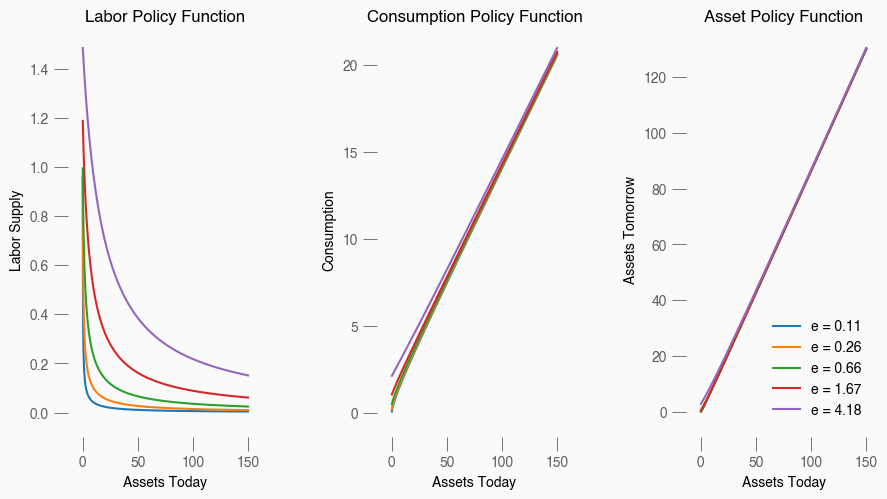

In [26]:
######################
## Policy Functions ##
######################

# Labor Policy Function

theme = load_theme("minimal_light")
theme.apply()

ax0 = plt.figure(figsize=(10, 5)) 
ax0.set_facecolor('#FAFAFA')

ax1 = plt.subplot(1,3,1)
plt.plot(ss0.internals['hh']['a_grid'], ss0.internals["hh"]['l'].T)
plt.xlabel('Assets Today'), plt.ylabel('Labor Supply')
plt.title('Labor Policy Function')
ax1.set_facecolor('#FAFAFA')

# Consumption Policy Function

ax2 = plt.subplot(1,3,2)
plt.plot(ss0.internals['hh']['a_grid'], ss0.internals["hh"]['c'].T)
plt.xlabel('Assets Today'), plt.ylabel('Consumption')
plt.title('Consumption Policy Function')
ax2.set_facecolor('#FAFAFA')

# Assets Policy Function

ax3 = plt.subplot(1,3,3)
for s, es in enumerate(ss0.internals["hh"]["e_grid"]):
    plt.plot(ss0.internals['hh']['a_grid'], ss0.internals["hh"]['a'][s].T, label=f'e = {es:.2f}')

plt.legend(loc='lower right', frameon=False)
plt.xlabel('Assets Today'), plt.ylabel('Assets Tomorrow')
plt.title('Asset Policy Function')
ax3.set_facecolor('#FAFAFA')

theme.apply_transforms()

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.7,
                    hspace=0.7)
plt.show()


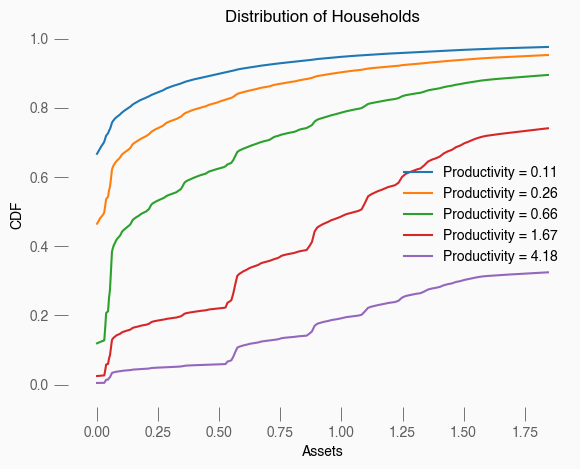

In [61]:
##########
## CDFs ##
##########

theme = load_theme("minimal_light")
theme.apply()

ax0 = plt.figure()
ax0.set_facecolor('#FAFAFA')

ax1 = plt.subplot(1,1,1)
for s, es in enumerate(ss0.internals["hh"]["e_grid"]):
    plt.plot(ss0.internals['hh']['a_grid'][:200], ss0.internals["hh"]['D'][s].cumsum()[:200]/ss0.internals["hh"]["pi_e"][s], label=f'Productivity = {es:.2f}')
    
plt.legend(frameon=False)
plt.xlabel('Assets'), plt.ylabel('CDF')
plt.title('Distribution of Households')
ax1.set_facecolor('#FAFAFA')

theme.apply_transforms()
plt.show()

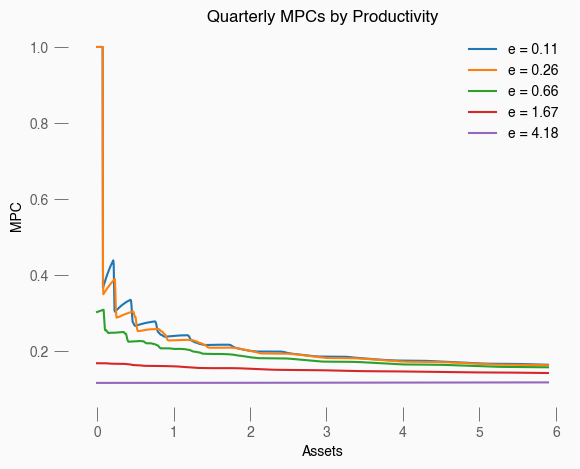

In [62]:
##########
## MPCs ##
##########

theme = load_theme("minimal_light")
theme.apply()

mpcs = np.empty_like(ss0.internals['hh']['c'])

# Symmetric differences away from boundaries
mpcs[:, 1:-1] = (ss0.internals['hh']['c'][:, 2:] - ss0.internals['hh']['c'][:, 0:-2])/(ss0.internals['hh']['a_grid'][2:] - ss0.internals['hh']['a_grid'][:-2])/(1+ss0['r'])

# Asymmetric differences at the boundaries
mpcs[:,0] = (ss0.internals['hh']['c'][:, 1] - ss0.internals['hh']['c'][:, 0])/(ss0.internals['hh']['a_grid'][1] - ss0.internals['hh']['a_grid'][0])/(1+ss0['r'])
mpcs[:,-1] = (ss0.internals['hh']['c'][:, -1] - ss0.internals['hh']['c'][:, -2])/(ss0.internals['hh']['a_grid'][-1] - ss0.internals['hh']['a_grid'][-2])/(1+ss0['r'])

# If constrained
mpcs[ss0.internals['hh']['a'] == ss0.internals['hh']['a_grid'][0]] = 1

ax0 = plt.figure()
ax0.set_facecolor('#FAFAFA')

ax1 = plt.subplot(1,1,1)
for s, es in enumerate(ss0.internals["hh"]["e_grid"]):
    plt.plot(ss0.internals['hh']['a_grid'][:300], mpcs[s,:300], label=f'e = {es:.2f}')
plt.xlabel('Assets')
plt.ylabel('MPC')
plt.title('Quarterly MPCs by Productivity')
plt.legend(frameon=False)
ax1.set_facecolor('#FAFAFA')

theme.apply_transforms()
plt.show()

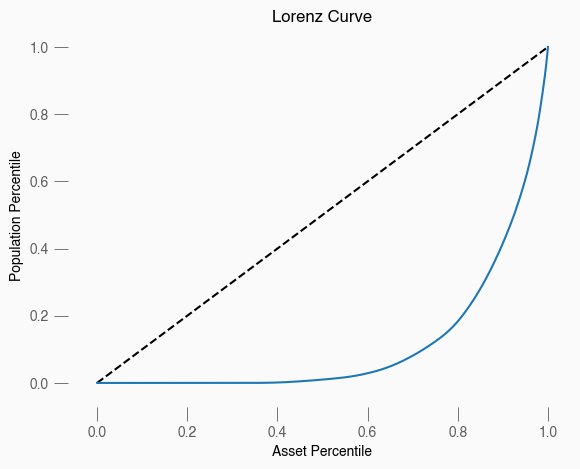

In [66]:
##################
## Lorenz Curve ##
##################

# Cumulative sum of the population
pop1 = (np.ones(((ss0.internals['hh']['a_grid'].size, cal['n_e'])))/(cal['n_a']*5))
pop2 = pop1.reshape(2500, 1)
pop = pop2.cumsum()

# Cumulative sum of assets
assets1 = (ss0.internals['hh']['D']*ss0.internals['hh']['a_grid'])/ss0['A']
assets2 = np.array(assets1)
assets3 = assets2.reshape(2500, 1)
assets4 = sorted(assets3)
assets4 = np.array(assets4)
assets5 = assets4.cumsum()
assets = assets5/assets5[-1]

theme = load_theme("minimal_light")
theme.apply()

ax0 = plt.figure()
ax0.set_facecolor('#FAFAFA')

ax1 = plt.subplot(1,1,1)
plt.plot([0,1], [0,1], linestyle = '--', color = 'k')
plt.plot(pop, assets);
plt.xlabel("Asset Percentile")
plt.ylabel("Population Percentile")
plt.title("Lorenz Curve")
ax1.set_facecolor('#FAFAFA')

theme.apply_transforms()
plt.show()

In [65]:
######################
## Gini Coefficient ##
######################

areaB = sum(assets)
areaA = sum(np.arange(2500)/2500 - assets)

gini = areaA/(areaA + areaB)

print(gini)

0.7746724642710526


In [12]:
#######################
## Dynamic Equations ##
#######################




## Government

@sj.simple
def govt(B, r, G, Y, I, mrs, Ld):
    Tax = (1+r)*B(-1) + G - B        # From government BC, solved for taxes
    
    Deficit = G - Tax                # Deficit. Bonds should make up the rest
    
    Div = Y - I - mrs*Ld
    
    return Tax, Div, Deficit





## Interest Rate

@sj.simple
def ex_post_rate(r_ante):
    r = r_ante(-1)
    
    return r





## Market Clearing

@sj.simple
def mkt_clearing(A, Y, C, G, B, I, r, beta, LE, Ld, vw):
    asset_mkt = A - B
    goods_mkt = Y - C - I - G
    labor_mkt = LE - Ld * vw
    
    return asset_mkt, goods_mkt, labor_mkt





## Production

@sj.solved(unknowns = {'pstar': 1.}, targets={'pres'})
def prices(phip, pstar, ep, Pi, gammap):
    pres = (1-phip) * pstar**(1-ep) + phip * Pi(-1)**(gammap*(1-ep)) * Pi**(ep-1) - 1
    
    return pres

@sj.solved(unknowns={'vp': 1.}, targets = ['vpres'])
def vpclear(phip, pstar, ep, Pi, gammap, vp):
    vpres = (1-phip) * pstar**(-ep) + phip * Pi**(ep) * Pi(-1)**(-ep*gammap) * vp(-1) - vp
    
    return vpres

@sj.solved(unknowns={'K': 32.0628, 'u': 1., 'I': 0.801571, 'pk': 1., 'x1': 9.51589, 'x2': 10.4675, 'pm': 0.909}, targets=['Kres', 'ures', 'Ires', 'pkres', 'x1res', 'x2res', 'pmres'])
def firm(Z, Ld, K, u, I, pk, x1, x2, pm, Pi, Lambda, alpha, vp, pstar, ep, gammap, kappa, delta0, delta1, delta2, phip):
    Ym = Z * (u * K(-1))**(alpha) * Ld**(1-alpha)
    Y = Ym/vp
    w = (1-alpha) * pm * Z * (u * K(-1))**(alpha) * Ld**(-alpha)
    Ihat = (1 - kappa/2 * (I/I(-1) - 1)**2) * I
    Kres = Ihat + (1 - delta0 - delta1 * (u - 1) - delta2/2 * (u - 1)**(2)) * K(-1) - K
    ures = pm * Z * alpha * K(-1)**(alpha-1) * u**(alpha-1) * Ld**(1-alpha) - pk * (delta1 + delta2 * (u - 1))
    Ires = pk * (1 - (kappa/2) * (I/I(-1) - 1)**(2)) - pk * I/I(-1) * kappa * (I/I(-1) - 1) + Lambda(1) * pk(1) * (I(1)/I)**(2) * kappa * (I(1)/I - 1) - 1
    pkres = alpha * Lambda(1) * pm(1) * Z(1) * u(1)**(alpha) * K**(alpha-1) * Ld(1)**(1-alpha) + pk(1) * (1 - delta0 - delta1 * (u(1) - 1) - delta2/2 * (u(1) - 1)**2) * Lambda(1) - pk
    x1res = pm * Y + phip * Lambda(1) * Pi**(-ep*gammap) * Pi(1)**(ep) * x1(1) - x1
    x2res = Y + phip * Lambda(1) * Pi**((1-ep)*gammap) * Pi(1)**(ep-1) * x2(1) - x2
    pmres = ep/(ep-1) * (pm * Y + phip * Lambda(1) * Pi**(-ep*gammap) * Pi(1)**(ep) * x1(1)) / (Y + phip * Lambda(1) * Pi**((1-ep)*gammap) * Pi(1)**(ep-1) * x2(1)) - pstar
    
    return Ym, Y, w, Ihat, Kres, ures, Ires, pkres, x1res, x2res, pmres





## Labor Markets

@sj.solved(unknowns={'vw': 1., 'wstar': 1.92538, 'f1': 7774.04, 'f2': 4441.45, 'mrs': 1.75}, targets=['vwres', 'wstarres', 'f1res', 'f2res', 'mrsres'])
def unions(Ld, Pi, w, phiw, ew, gammaw, Lambda, vw, wstar, f1, f2, mrs, eta, chi):
    vwres = (1-phiw) * (wstar/w)**(-ew) + phiw * (Pi/Pi(-1)**(gammaw))**(ew) * (w/(w(-1)))**(ew) * vw(-1) - vw
    wstarres = (1-phiw) * wstar**(1-ew) + phiw * (w(-1) * Pi(-1)**(gammaw)/Pi)**(1-ew) - w**(1-ew)
    f1res = mrs * w**(ew) * Ld + phiw * Lambda(1) * Pi(1)**(ew) * Pi**(-ew*gammaw) * f1(1) - f1
    f2res = w**(ew) * Ld + phiw * Lambda(1) * Pi(1)**(ew-1) * Pi**(gammaw*(1-ew)) * f2(1) - f2
    mrsres = ew/(ew-1) * (mrs * w**(ew) * Ld + phiw * Lambda(1) * Pi(1)**(ew) * Pi**(-ew*gammaw) * f1(1)) / (w**(ew) * Ld + phiw * Lambda(1) * Pi(1)**(ew-1) * Pi**(gammaw*(1-ew)) * f2(1)) - wstar
    
    return vwres, wstarres, f1res, f2res, mrsres

@sj.simple
def deltaone(beta, delta0):
    delta1 = 1/beta - 1 + delta0
    Lambda = beta
    
    return delta1, Lambda





## Central Bank

@sj.solved(unknowns = {'i': 0.04}, targets = ['ires'])
def fed(Pi, ishock, rss, phipi, rhor, i, beta, Yss, phiy, Y):
    ires = (1-rhor) * (1+rss).apply(np.log) + rhor * (1+i(-1)).apply(np.log) + (1-rhor) * phipi * (Pi).apply(np.log) + (1-rhor) * phiy * ((Y).apply(np.log) - (Yss).apply(np.log)) + ishock - (1+i).apply(np.log)
    r_ante = i - (Pi(1)-1)
    
    return ires, r_ante

In [13]:
ha = sj.create_model([hh2, govt, ex_post_rate, mkt_clearing, prices, vpclear, firm, unions, fed, deltaone], name = "Third Year Paper - HANK")

ss0['Yss'] = ss0['Y']
ss0['phiy'] = 0.5
ss = ha.steady_state(ss0, dissolve=['prices', 'vpclear', 'firm', 'unions', 'fed'])

ss.toplevel

{'beta': 0.8716790681724409,
 'sigma': 1.0,
 'eta': 1.0,
 'chi': 0.9755334384460216,
 'rho_e': 0.75,
 'sd_e': 0.92,
 'n_e': 5,
 'min_a': -1e-06,
 'max_a': 150,
 'n_a': 500,
 'T': 0.4761708102661102,
 'B': 1.0,
 'G': 0.47117081026611035,
 'Ld': 1.0,
 'phip': 0.7,
 'ep': 11.0,
 'Pi': 1.0,
 'gammap': 0.25,
 'Z': 1.0,
 'alpha': 0.3333333333333333,
 'kappa': 2.0,
 'delta0': 0.02,
 'delta2': 0.01,
 'phiw': 0.7,
 'ew': 11.0,
 'gammaw': 0.6,
 'ishock': 0.0,
 'rss': 0.005,
 'phipi': 1.5,
 'rhor': 0.8,
 'Yss': 1.3462023150460296,
 'phiy': 0.5,
 'pstar': 1,
 'vp': 1,
 'K': 2.4396695135069826,
 'u': 1.0,
 'I': 0.04879339027013965,
 'pk': 1,
 'x1': 3.1394122440688297,
 'x2': 3.453353468475713,
 'pm': 0.9090909090909091,
 'vw': 1,
 'wstar': 0.8158801909369877,
 'f1': 0.2028872151239007,
 'f2': 0.2735400848254289,
 'mrs': 0.7417092644881706,
 'i': 0.005,
 'delta1': 0.16721121168665462,
 'Lambda': 0.8716790681724409,
 'pres': 0.0,
 'vpres': 0.0,
 'Ym': 1.3462023150460296,
 'Y': 1.3462023150460296,
 'w

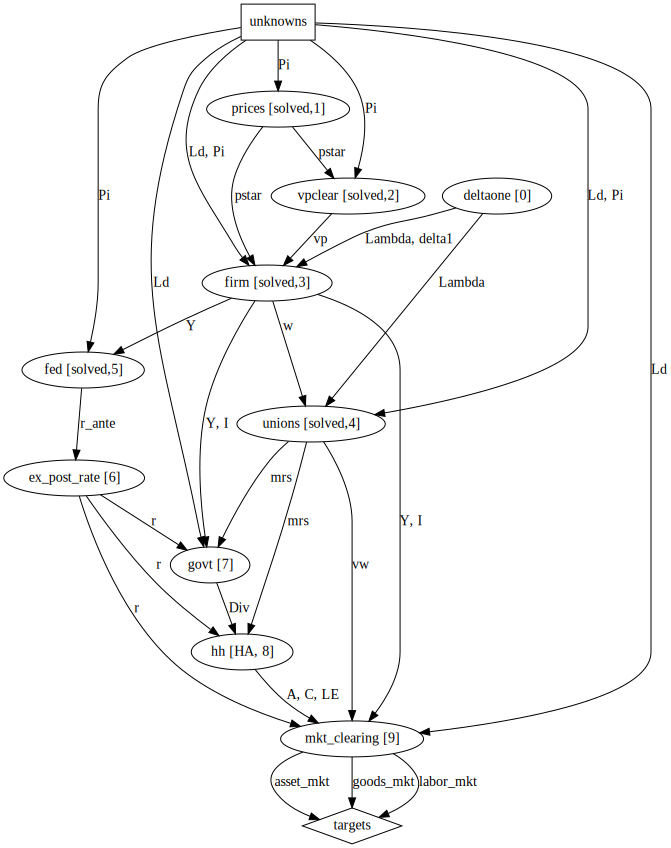

In [14]:
sj.drawdag(ha, unknowns={'Pi', 'Ld'}, targets={'asset_mkt', 'labor_mkt', 'goods_mkt'})

In [15]:
##########
## IRFs ##
##########

T = 400
da = 0.0065 * 0.95 ** np.arange(T)

irf_prod = ha.solve_impulse_linear(ss0, ['Pi', 'Ld'], {'asset_mkt': 0., 'labor_mkt':0.}, {'Z': da})


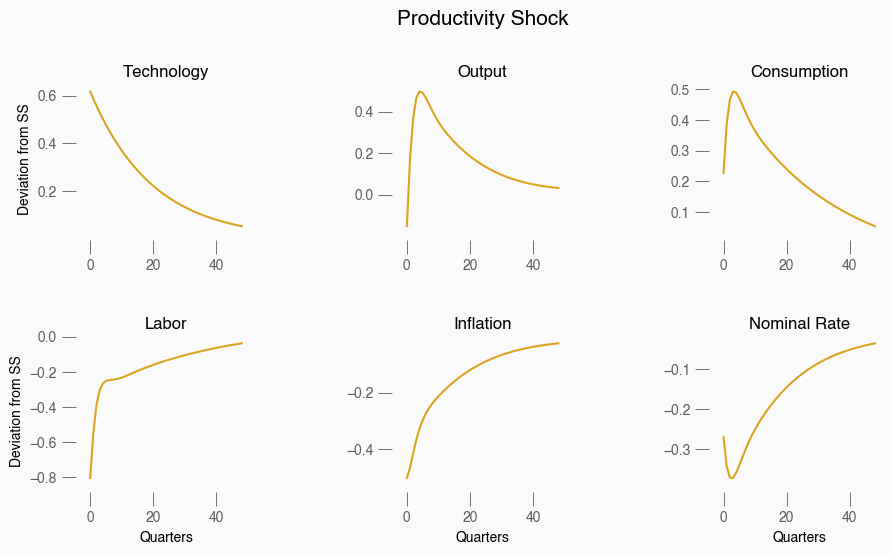

In [24]:
Thorizon = 50

# cp = (irf_prod['ep'])/(irf_prod['ep'] - 1)
theme = load_theme("minimal_light")
theme.apply()
ax0 = plt.figure(figsize=(10, 5)) 
ax0.set_facecolor('#FAFAFA')

ax1 = plt.subplot(2,3,1)
plt.plot(100*irf_prod['Z'][1:Thorizon], color='goldenrod')
plt.ylabel('Deviation from SS')
plt.title('Technology')
ax1.set_facecolor('#FAFAFA')

ax2 = plt.subplot(2,3,2)
plt.plot(100*irf_prod['Y'][1:Thorizon], color='goldenrod')
plt.title('Output')
ax2.set_facecolor('#FAFAFA')

ax3 = plt.subplot(2,3,3)
plt.plot(100*irf_prod['C'][1:Thorizon], color='goldenrod')
plt.title('Consumption')
ax3.set_facecolor('#FAFAFA')

ax4 = plt.subplot(2,3,4)
plt.plot(100*irf_prod['Ld'][1:Thorizon], color='goldenrod')
plt.xlabel('Quarters')
plt.ylabel('Deviation from SS')
plt.title('Labor')
ax4.set_facecolor('#FAFAFA')

ax5 = plt.subplot(2,3,5)
plt.plot(100*irf_prod['Pi'][1:Thorizon], color='goldenrod')
plt.xlabel('Quarters')
plt.title('Inflation')
ax5.set_facecolor('#FAFAFA')

ax6 = plt.subplot(2,3,6)
plt.plot(100*irf_prod['i'][1:Thorizon], color='goldenrod')
plt.xlabel('Quarters')
plt.title('Nominal Rate')
ax6.set_facecolor('#FAFAFA')

plt.suptitle('Productivity Shock', y=1.05, fontsize=15)

theme.apply_transforms()

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.9,
                    hspace=0.7)

plt.show()